In [1]:
import os
import warnings

import pandas as pd
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from strandtools.normalization import library_normalization, gc_correction, vst, smoothing
from strandtools.cn import CopyNumberClassifier

In [2]:
PATH_TO_DATA = '../resources/BM510x3.txt.raw.gz'
cwd = os.getcwd()
PATH_TO_STRANDTOOLS = os.path.join(cwd, "../")

In [3]:
# If not already present, download the test data:
if not os.path.isfile(PATH_TO_DATA):
    os.makedirs("../resources", exist_ok=True)

    # Download the test data
    print("Downloading test data...")
    !wget https://github.com/friendsofstrandseq/mosaicatcher-testdata/raw/main/data_ALL_CHROM/RPE-BM510/counts/BM510x3.txt.raw.gz resources/
else:
    print("Test data already present.")

Test data already present.


In [4]:
GC_path = os.path.join(PATH_TO_STRANDTOOLS,'resources', 'GRCh38.GC_matrix_200000.txt')
exclusion_path = os.path.join(PATH_TO_STRANDTOOLS,'resources', 'GRCh38.centromere.exclusion.bed')

## load data and normalization

In [5]:
craw = pd.read_csv(PATH_TO_DATA, sep='\t')

  0%|          | 0/50 [00:00<?, ?it/s]

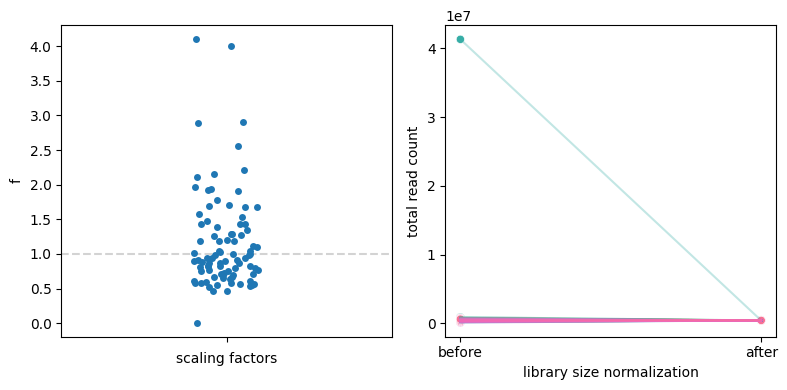

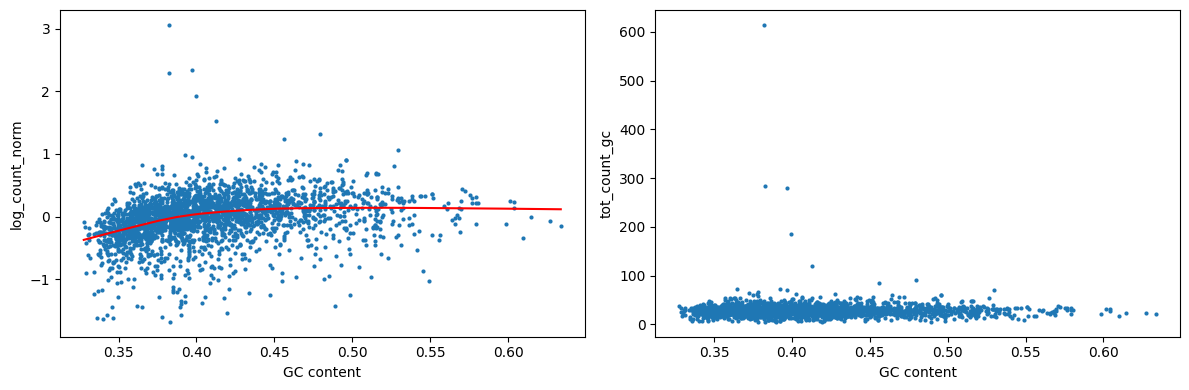

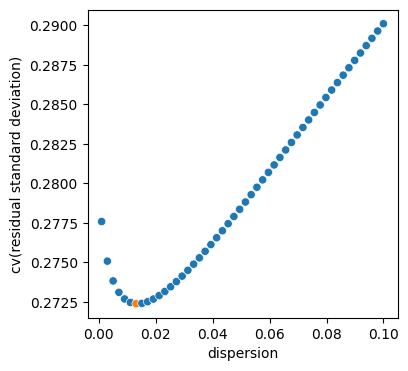

In [6]:
craw['tot_count'] = craw['w'] + craw['c']
counts = library_normalization(craw, plot=True)
counts = gc_correction(counts, n_subsample=250, GC_path=GC_path, plot=True)
counts = vst(counts, phi_max=.1, plot=True)
counts = smoothing(counts, apply=True, clip_negative=True)

## load data into copy number classifier

In [7]:
cnc = CopyNumberClassifier()
cnc.load_counts(counts)

## segment

In [8]:
cnc.cbs_segmentation(exclusion_bed=exclusion_path, n_workers=10)

86it [00:22,  3.77it/s]
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide


iteration 0		num edges 29047		time 39.269530057907104
iteration 1		num edges 32865		time 11.00824499130249
iteration 2		num edges 33397		time 2.7959060668945312
iteration 3		num edges 33480		time 0.679218053817749
iteration 4		num edges 33491		time 0.4724760055541992
iteration 5		num edges 33493		time 0.5169668197631836
tolerance reached
iteration 0		num edges 29047		time 42.7216911315918
iteration 1		num edges 32714		time 11.92264699935913
iteration 2		num edges 33221		time 2.773085832595825
iteration 3		num edges 33316		time 0.790452241897583
iteration 4		num edges 33336		time 0.4527120590209961
iteration 5		num edges 33339		time 0.44423818588256836
tolerance reached


## filter data

100%|██████████| 100/100 [00:03<00:00, 26.98it/s]
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:373: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[1,0].axvspan(l,r, facecolor=col, linestyle='--', color=col, alpha=.3)
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:382: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.scatterplot(data=counts, x='z_tot_count', y='z_wf',


(array([1874, 1934]),
 {'prominences': array([0.03967822, 0.04099428]),
  'left_bases': array([174, 174]),
  'right_bases': array([1891, 1946])})

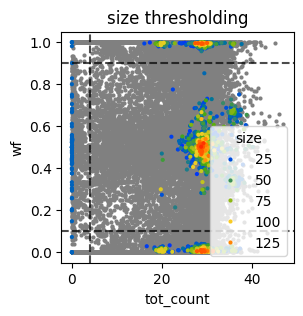

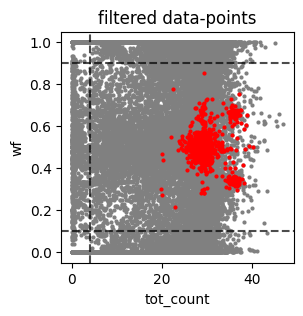

In [9]:
cnc.filter_counts(low_threshold=4, size_threshold = 20, plot=True)
cnc.compute_reachability(min_samples=10, n_subsample=2000, random_state=30, plot=True)
cnc.extract_clusters(prominence=None, plot=True)

## fit models and predict

/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:424: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.scatterplot(x=X[:,0], y=X[:,1],
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:471: UserWarning: The palette list has more values (256) than needed (3), which may not be intended.
  sns.scatterplot(x=X[:,0], y=X[:,1],


threshold 25.96
(1649, 23)
(151, 23)


/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:619: UserWarning: predicting on segm_id_1
  warnings.warn('predicting on {}'.format(segm_id_col))
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:699: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.scatterplot(data=self.counts_merged, x='tot_count', y='wf',


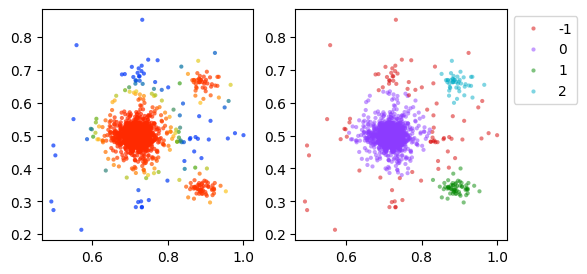

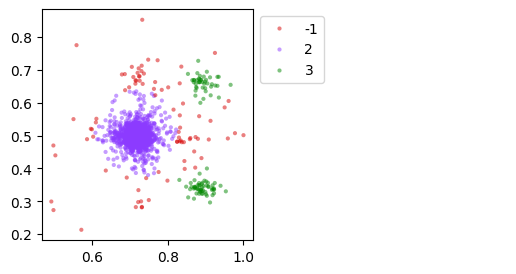

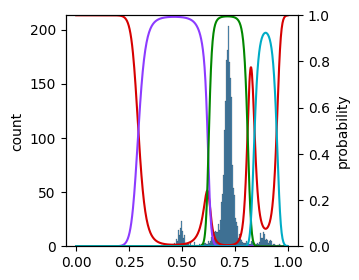

In [10]:
cnc.fit_WC(calibrated=False, plot=True)
cnc.fit_copy_number(plot=True)
cnc.fit_WW(cn1=True, calibrated=False, plot=True)
c, cm = cnc.predict_copy_number(plot=True)

## merge into super-segments

In [11]:
cnc.get_changepoints()
cnc.merge_supersegments()
cnc.filter_counts(low_threshold=10, size_threshold = 20, plot=True)
c, cm = cnc.predict_copy_number(plot=True)

/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:619: UserWarning: predicting on super_segm_id
  warnings.warn('predicting on {}'.format(segm_id_col))
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/cn.py:699: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.scatterplot(data=self.counts_merged, x='tot_count', y='wf',


## QC

9it [00:00, 28.25it/s]


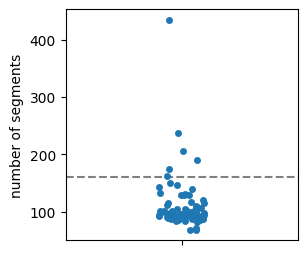

In [12]:
cnc.pred_qc_pass(
    probability_pass_stringency=.5,
    exclusion_bed=exclusion_path,
    exclusion_score_threshold=.3,
    low_count_threshold=.05,
    cv_threshold=0.5,
    stderr_threshold=1.5,
    n_segm_threshold=160)

cnc.get_changepoints()

## visualize results

In [13]:
from strandtools.plot import plot_cn_overview

In [14]:
# assign copy number -1 to all low quality segments
idxs = cnc.counts_merged.loc[cnc.counts_merged['pred_QC_pass'], 'super_segm_id'].values
tmp = cnc.counts.copy()
tmp.loc[~tmp['super_segm_id'].isin(idxs), 'pred'] = -1

plot_cn_overview(tmp, row_cluster=False)
